# Train model to recognise voice of people 

In [3]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
import sys
sys.path.append('../')

In [5]:
def filter_sample_by_clients_ids(data: pd.DataFrame, max_count: int = 500, min_count: int = 4):
	sample_count = data['client_id'].value_counts()
	clients_ids = [e for e in sample_count[sample_count < max_count][sample_count > min_count].index]
	return data[data['client_id'].isin(clients_ids)]

def concatenation(train_data: pd.DataFrame, anchor: pd.DataFrame, posneg: pd.DataFrame) -> pd.DataFrame:
		data_particle_case = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
		data_particle_case[['anchor_client_id', 'anchor_path', 'anchor_source']] = anchor
		data_particle_case[['posneg_client_id', 'posneg_path', 'posneg_source']] = posneg
		return pd.concat([train_data, data_particle_case], ignore_index=True)

def data_generation_base(data: pd.DataFrame, data_frac: int = 1):
	client_ids = data['client_id'].unique()
	data['source'] = 'original'
	
	res_data = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
	for id in client_ids:
		client_id_sample = data[data['client_id'] == id] 
		no_client_id_sample = data[data['client_id'] != id]

		anchor_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_original, positive_original)

		anchor_neg_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_generated = no_client_id_sample.sample(frac=3, replace = True).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_neg_original, negative_generated)
	return res_data

In [6]:
DATASET_PATH = '../dataset/'
DATA_PATH = '../data/'
MODEL_SAVE_PATH = '../model_save/'
BATCH_SIZE = 24

In [7]:
from src.dataset.universal_dataset import UniversalDS

class BaseUniversalDS(UniversalDS):
	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label = anchor_client_id == posneg_client_id
		return torch.tensor(1 if label else 0, dtype=torch.int64)

	def mix_dataset(self):
		self.temp_dataset = data_generation_base(self.voice_dataset, data_frac=1)
		self.reset_iteration()

voice_df = pd.read_csv(DATA_PATH + "validated.tsv",  sep='\t')
voice_df = filter_sample_by_clients_ids(voice_df, min_count=3)[['client_id', 'path']]
train_ds = BaseUniversalDS(voice_df, DATA_PATH + "validated_16000/")

In [8]:
from src.dataset.base_dataset import BaseSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/")

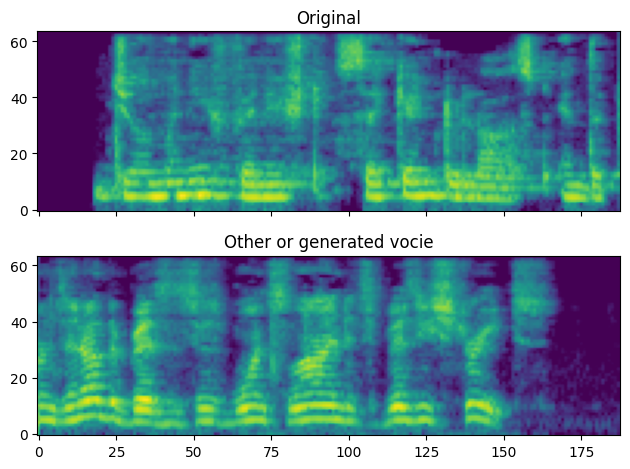

In [9]:
from src.utils.plot import plot

plot(test_ds[11])
train_ds.reset_iteration()

In [5]:
import torchvision
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				AlexNet = torchvision.models.alexnet(pretrained=True)
				self.conv_layers = AlexNet.features
				self.conv_layers[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
				self.avgpool = AlexNet.avgpool
				self.fc_layers = nn.Sequential(
						nn.Linear(9216, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = self.avgpool(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [9]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def train_siamese_model(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	predictions = []
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		
		optimizer.zero_grad()
		output = model(anchor_sgram, posneg_sgram)
		loss = criterion(output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		predictions += [torch.argmax(pred) for pred in output.cpu()]
		true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss, accuracy, precision, recall, f1

def evaluate_siamese_model(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred) for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)

	return avg_loss, accuracy, precision, recall, f1

In [11]:
class CrossEntropyLoss(torch.nn.Module):
	def __init__(self):
		super(CrossEntropyLoss, self).__init__()

	def forward(self, output, label):
		label = label.long()
		loss = F.cross_entropy(output, label)
		return loss

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
siamese_model = SiameseNetwork().to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.00001)


c:\Users\Yuriy\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yuriy\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import copy
siamese_model.to(device)
loss, accuracy, precision, recall, f1 = [], [], [], [], []
best_accuracy=0
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	if _test_accuracy > best_accuracy:
		best_accuracy = _test_accuracy
		best_model = copy.deepcopy(siamese_model)
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])


Epoch 1/10, Loss: 0.6820, Accuracy: 0.6042, Precision: 0.6128, Recall: 0.5661, F1: 0.5885


Epoch 1/10, Loss: 0.6324, Accuracy: 0.6909, Precision: 0.6691, Recall: 0.7552, F1: 0.7096


Epoch 2/10, Loss: 0.5856, Accuracy: 0.6918, Precision: 0.6914, Recall: 0.6928, F1: 0.6921


Epoch 2/10, Loss: 0.5717, Accuracy: 0.7199, Precision: 0.7409, Recall: 0.6763, F1: 0.7072


Epoch 3/10, Loss: 0.5363, Accuracy: 0.7305, Precision: 0.7218, Recall: 0.7500, F1: 0.7356


Epoch 3/10, Loss: 0.5175, Accuracy: 0.7531, Precision: 0.7259, Recall: 0.8133, F1: 0.7671


Epoch 4/10, Loss: 0.4895, Accuracy: 0.7637, Precision: 0.7584, Recall: 0.7738, F1: 0.7660


Epoch 4/10, Loss: 0.5440, Accuracy: 0.7324, Precision: 0.6739, Recall: 0.9004, F1: 0.7709


Epoch 5/10, Loss: 0.4451, Accuracy: 0.7930, Precision: 0.7829, Recall: 0.8107, F1: 0.7966


Epoch 5/10, Loss: 0.5253, Accuracy: 0.7448, Precision: 0.6855, Recall: 0.9046, F1: 0.7800


Epoch 6/10, Loss: 0.3924, Accuracy: 0.8242, Precision: 0.8142, Recall: 0.8402, F1: 0.8270


Epoch 6/10, Loss: 0.4586, Accuracy: 0.7842, Precision: 0.7387, Recall: 0.8797, F1: 0.8030


Epoch 7/10, Loss: 0.3723, Accuracy: 0.8319, Precision: 0.8171, Recall: 0.8551, F1: 0.8357


Epoch 7/10, Loss: 0.4734, Accuracy: 0.7593, Precision: 0.7148, Recall: 0.8631, F1: 0.7820


Epoch 8/10, Loss: 0.3451, Accuracy: 0.8462, Precision: 0.8367, Recall: 0.8604, F1: 0.8484


Epoch 8/10, Loss: 0.5026, Accuracy: 0.7697, Precision: 0.7241, Recall: 0.8714, F1: 0.7910


Epoch 9/10, Loss: 0.3264, Accuracy: 0.8571, Precision: 0.8464, Recall: 0.8725, F1: 0.8592


Epoch 9/10, Loss: 0.4688, Accuracy: 0.8008, Precision: 0.7562, Recall: 0.8880, F1: 0.8168


Epoch 10/10, Loss: 0.3204, Accuracy: 0.8613, Precision: 0.8495, Recall: 0.8782, F1: 0.8636


Epoch 10/10, Loss: 0.4657, Accuracy: 0.7801, Precision: 0.7437, Recall: 0.8548, F1: 0.7954


In [23]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")
	plt.tight_layout()
	plt.show()

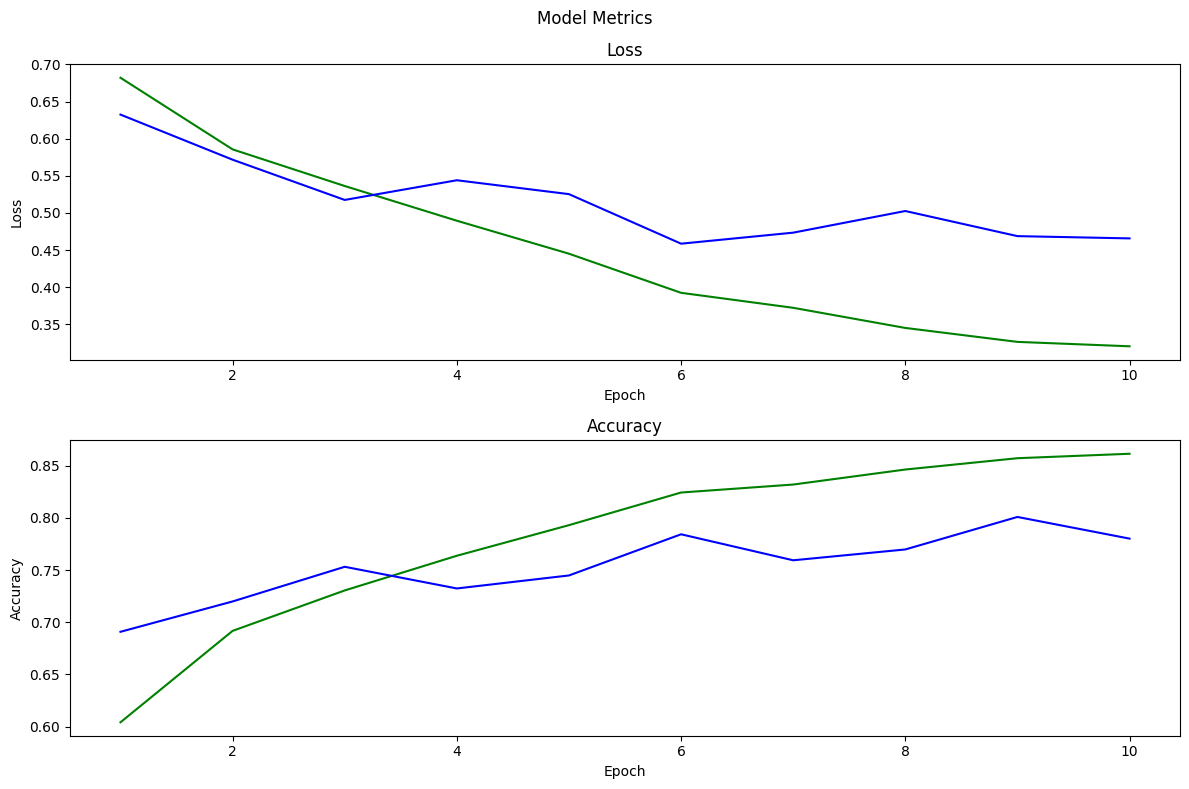

In [15]:
plot_metrix(loss, accuracy)

In [74]:
def save_model(model, model_name, base_path = '../model_save/'):
	model.cpu()
	model.eval()
	torch.save(model, base_path + model_name)

In [75]:
save_model(best_model, "base_cnn_mix_alex.pt")

In [18]:
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad[0]), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad[0]), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad

In [19]:
def plot_explain_siamese_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad, label):
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title("Anchor Sgram Grad")
	plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
				 origin="lower", aspect="auto")
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	text_label = "Positive" if label else "Negative"
	plt.title(f"{text_label} Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title(f"{text_label} Sgram Grad")
	plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
				 origin="lower", aspect="auto")
	plt.show()

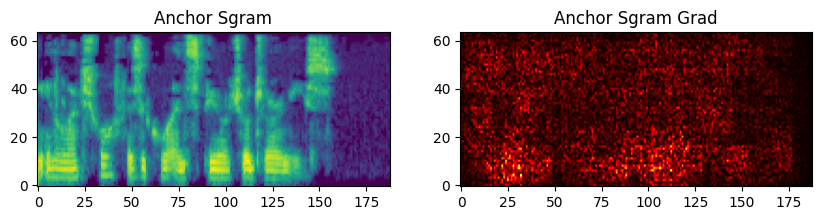

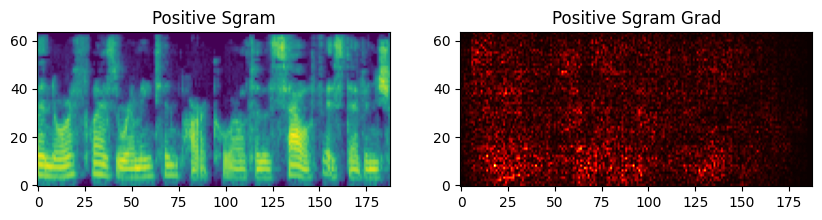

In [20]:
anchor_sgram, posneg_sgram, label = test_ds[4]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, label)

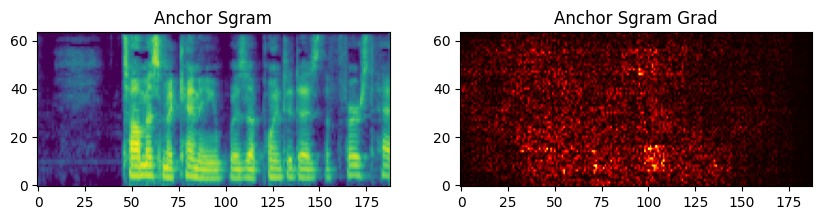

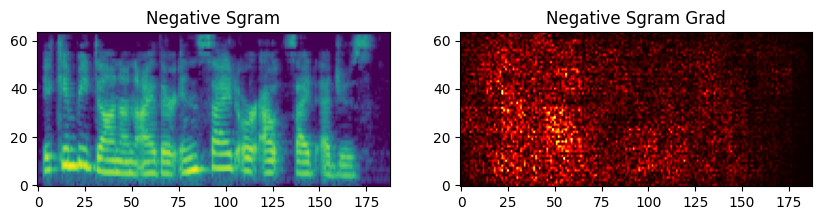

In [21]:
anchor_sgram, posneg_sgram, label = train_ds[4]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, label)

In [90]:
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [84]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "Negative","Positive"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()


In [88]:
from src.dataset.base_dataset import BaseSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7863070539419087


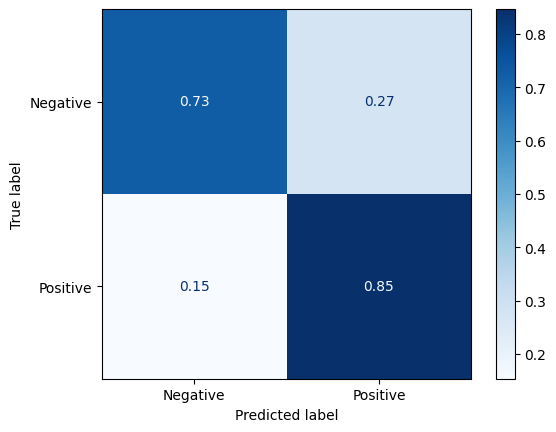

In [91]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

accuracy: 0.8636363636363636


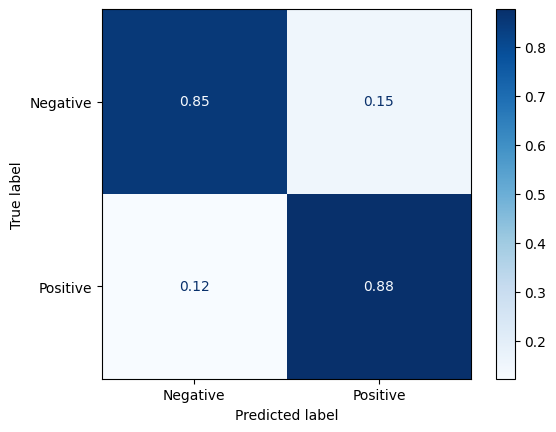

In [26]:
avg_loss, true_labels, predictions = test(best_model, train_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [27]:
from src.dataset.generated_dataset import GeneratedSoundDS
import librosa
from src.columns.generated_dataset_column import GeneratedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class GeneratedSoundDS(Dataset):
	def __init__(
		self,
		voiceDataset,
		original_voice_data_path,
		generated_voice_data_path,
		sample_rate=16000,
		duration=3,
		transform=None
	):
		self.voiceDataset = voiceDataset
		self.original_voice_data_path = str(original_voice_data_path)
		self.generated_voice_data_path = str(generated_voice_data_path)
		self.duration = duration
		self.sample_rate = sample_rate
		self.transform = None
		if transform is not None:
			self.transform = transform
		else:
			self.transform = CompositeTransformation(
				[
					ResampleTransform(target_sample_rate=sample_rate),
					CustomAdjustDurationTransform(duration_seconds=duration),
					ToMelSpectrogramTransform(
						sample_rate=sample_rate, n_mels=64, n_fft=512)
				]
			)

	def __len__(self):
		return len(self.voiceDataset)

	def _get_sgram(self, audio_file):
		audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
		spectrogram = self.transform.transform((audio, sample_rate))
		return spectrogram

	def _get_sample_path(self, path, source):
		data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
		return data_path + path

	def _get_label(self, label):
		return torch.tensor(1 if label else 0, dtype=torch.int64)

	def __getitem__(self, idx):
		anchor_path, posneg_path, _, _, anchor_source, posneg_source, label = self.voiceDataset.iloc[idx][
			[
				GeneratedDatasetColumn.ANCHOR_PATH,
				GeneratedDatasetColumn.POSNEG_PATH,
				GeneratedDatasetColumn.ANCHOR_ID,
				GeneratedDatasetColumn.POSNEG_ID,
				GeneratedDatasetColumn.SOURCE_ANCHOR,
				GeneratedDatasetColumn.SOURCE_POSNEG,
				GeneratedDatasetColumn.LABEL
			]
		].values.tolist()

		anchor_file = self._get_sample_path(anchor_path, anchor_source)
		posneg_file = self._get_sample_path(posneg_path, posneg_source)
		label = self._get_label(label)
		anchor_sgram = self._get_sgram(anchor_file)
		posneg_sgram = self._get_sgram(posneg_file)

		return anchor_sgram, posneg_sgram, label

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset_.csv")
test_ds = GeneratedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


accuracy: 0.6037344398340249


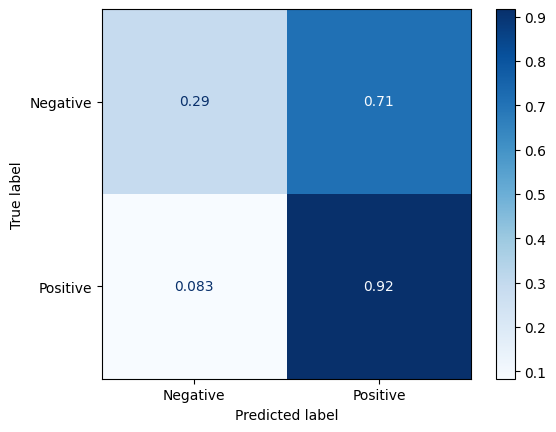

In [28]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [29]:
from src.dataset.combined_dataset import CombinedSoundDS
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedSoundDS(Dataset):
	def __init__(
		self,
		voiceDataset,
		original_voice_data_path,
		generated_voice_data_path,
		sample_rate=16000,
		duration=3,
		transform=None
	):
		self.voiceDataset = voiceDataset
		self.original_voice_data_path = str(original_voice_data_path)
		self.generated_voice_data_path = str(generated_voice_data_path)
		self.duration = duration
		self.sample_rate = sample_rate
		self.transform = None
		if transform is not None:
			self.transform = transform
		else:
			self.transform = CompositeTransformation(
				[
					ResampleTransform(target_sample_rate=sample_rate),
					CustomAdjustDurationTransform(duration_seconds=duration),
					ToMelSpectrogramTransform(
						sample_rate=sample_rate, n_mels=64, n_fft=512)
				]
			)

	def __len__(self):
		return len(self.voiceDataset)

	def _get_sgram(self, audio_file):
		audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
		spectrogram = self.transform.transform((audio, sample_rate))
		return spectrogram

	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
		return torch.tensor(1 if label else 0, dtype=torch.int64)

	def _get_sample_path(self, path, source):
		data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
		return data_path + path

	def __getitem__(self, idx):
		anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
			[
				CombinedDatasetColumn.ANCHOR_PATH,
				CombinedDatasetColumn.POSNEG_PATH,
				CombinedDatasetColumn.ANCHOR_ID,
				CombinedDatasetColumn.POSNEG_ID,
				CombinedDatasetColumn.SOURCE_ANCHOR,
				CombinedDatasetColumn.SOURCE_POSNEG
			]
		].values.tolist()

		anchor_file = self._get_sample_path(anchor_path, anchor_source)
		posneg_file = self._get_sample_path(posneg_path, posneg_source)
		label = self._get_label(
			anchor_client_id, posneg_client_id, anchor_source, posneg_source)
		anchor_sgram = self._get_sgram(anchor_file)
		posneg_sgram = self._get_sgram(posneg_file)

		return anchor_sgram, posneg_sgram, label

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.696058091286307


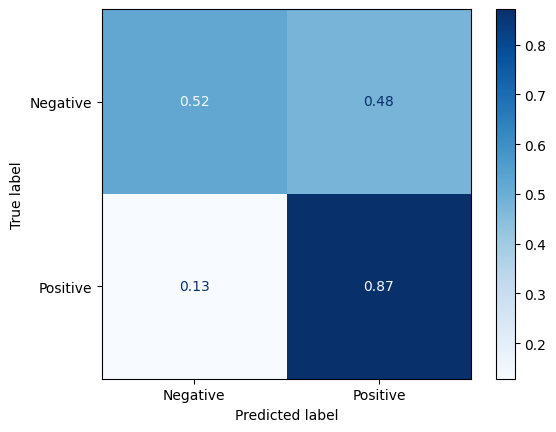

In [30]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [31]:
SAMPLE_RATE = 16000

In [32]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
		AirAbsorptionWrapperTransform(),
		EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/",  transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7199170124481328


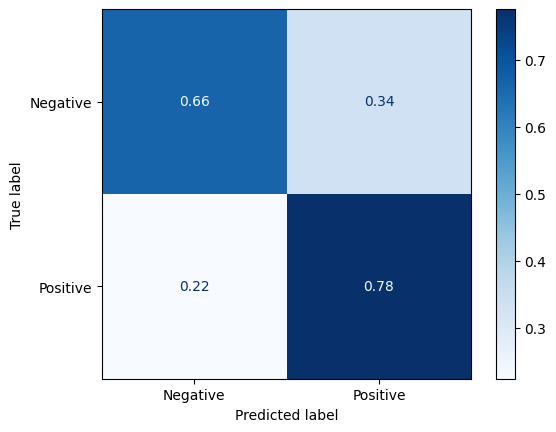

In [33]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [10]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
import librosa
def get_audio(path):
	SAMPLE_RATE = 16000
	transform = CompositeTransformation(
		[
			ResampleTransform(target_sample_rate=SAMPLE_RATE),
			CustomAdjustDurationTransform(duration_seconds=3),
			ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
		]
	)
	audio, sample_rate = librosa.load(path, sr = SAMPLE_RATE)
	return transform.transform((audio, sample_rate))

In [97]:
def test(model, speech_1, speach_2, device='cpu'):
	model.eval()
	model.cpu()

	with torch.no_grad():
		anchor_sgram = torch.unsqueeze(get_audio(speech_1), 0)
		posneg_sgram = torch.unsqueeze(get_audio(speach_2), 0)
		output = model(anchor_sgram, posneg_sgram)
		print(torch.argmax(output).item())

In [11]:
original_audio_path = DATA_PATH + "KAGGLE/AUDIO/REAL/"
generated_audio_path = DATA_PATH + "KAGGLE/AUDIO/FAKE/"

In [9]:
def get_sampels(path):
	import os

	directory_path = path

	file_list = os.listdir(directory_path)
	speech = []
	for filename in file_list:
		speech.append(filename)
	return speech


In [16]:
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				self.conv_layers = nn.Sequential(
						nn.Conv2d(1, 32, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(32, 64, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(64, 128, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(128, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
				)
				self.fc_layers = nn.Sequential(
						nn.Linear(4608, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [89]:
import torch
model = SiameseNetwork()
model = torch.load('../model_save/' + "base_cnn.pt")
model.eval()

SiameseNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
  )
  (final): Linear(in_features=1024, out_features=2, bias=True)
)

In [90]:
original_speach = get_sampels(original_audio_path)
generated_speach = get_sampels(generated_audio_path)

In [100]:
def test_g(model, original_audio_path, generated_audio_path, device='cpu'):
	model.eval()
	model.to("cuda")
	original_speach = get_sampels(original_audio_path)
	generated_speach = get_sampels(generated_audio_path)
	res = []
	with torch.no_grad():
		for sample in original_speach:
			for generated_sample in generated_speach[:50]:
				g_s =  generated_sample
				o_s = sample
				if g_s.replace(".", "-").split("-")[-2].lower()  == o_s.replace(".", "-").split("-")[0].lower():
						print(g_s, o_s)
						tem = []
						for _ in range(10):

							anchor_sgram = torch.unsqueeze(get_audio(original_audio_path + sample), 0).to("cuda")
							posneg_sgram = torch.unsqueeze(get_audio(generated_audio_path + generated_sample), 0).to("cuda")
							output = model(anchor_sgram, posneg_sgram)
							tem.append(torch.argmax(output).cpu().item())
						res.append(round(sum(tem)/10))
	return res
				

In [101]:
t = test_g(model, original_audio_path,  generated_audio_path)

linus-to-biden.wav biden-original.wav
margot-to-biden.wav biden-original.wav
musk-to-biden.wav biden-original.wav
Obama-to-Biden.wav biden-original.wav
ryan-to-biden.wav biden-original.wav
taylor-to-biden.wav biden-original.wav
trump-to-Biden.wav biden-original.wav
biden-to-linus.wav linus-original.wav
margot-to-linus.wav linus-original.wav
musk-to-linus.wav linus-original.wav
obama-to-linus.wav linus-original.wav
ryan-to-linus.wav linus-original.wav
taylor-to-linus.wav linus-original.wav
biden-to-margot.wav margot-original.wav
linus-to-margot.wav margot-original.wav
musk-to-margot.wav margot-original.wav
obama-to-margot.wav margot-original.wav
ryan-to-margot.wav margot-original.wav
taylor-to-margot.wav margot-original.wav
biden-to-musk.wav musk-original.wav
linus-to-musk.wav musk-original.wav
margot-to-musk.wav musk-original.wav
obama-to-musk.wav musk-original.wav
ryan-to-musk.wav musk-original.wav
taylor-to-musk.wav musk-original.wav
biden-to-Obama.wav obama-original.wav
linus-to-oba

In [94]:
test(model, original_audio_path + original_speach[14],  generated_audio_path + generated_speach[0])

IndexError: list index out of range

In [103]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy_score([1 for i in t], t)


0.26

In [38]:
original_speach[1].replace(".", "-").split("-")

['linus', 'original', 'wav']

In [87]:
generated_speach[0]

'biden-to-linus.wav'

In [36]:
generated_speach[0].replace(".", "-").split("-")

['biden', 'to', 'linus', 'wav']

In [111]:
sp_1 = get_audio(original_audio_path + original_speach[0])


In [112]:
sp_2 = get_audio(generated_audio_path + generated_speach[6])

In [19]:
sp_2 = get_audio('./audio_2024-05-14_23-14-48.ogg')

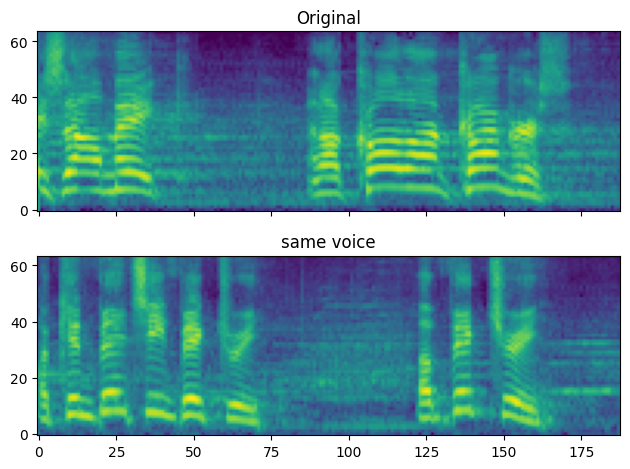

In [113]:
plot((sp_1, sp_2, 1))

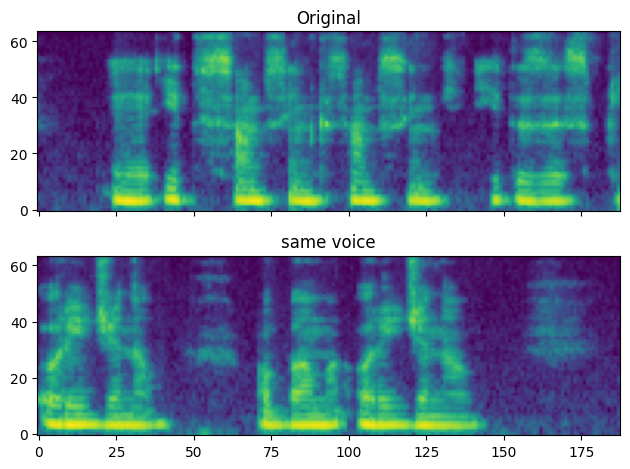

In [18]:
plot((sp_1, sp_2, 1))

In [17]:
sp_1 = get_audio('./audio_2024-05-14_23-14-48.ogg')
sp_2 = get_audio('./audio_2024-05-14_23-14-48.ogg')